# TP 1: Équation de Poisson en 1D

On s'intéresse à la résolution numérique de l'équation de Poisson

$$
\left\{\begin{aligned}
&u''(t) = f(t) \hbox{ sur } ]0,1[\\
&u(0) = u(1) = 0
\end{aligned}\right.$$

où $f: [0,1]\to\mathbb{R}$ est continue. On considèrera deux méthodes différentes: la méthode de tir, qui passe par la résolution du problème de Cauchy pour l'équation correspondante, et la méthode des différences finies. 

## 1. Méthode du tir
L'idée de la méthode du tir est la suivante: étant donné $a\in\mathbb{R}$, on considère le problème de Cauchy 

$$
\left\{\begin{aligned}
&u_a''(t) = f(t) \hbox{ sur } ]0,1[ \\
&u_a(0) = 0, u_a'(0) = a
\end{aligned}\right.,$$

et on note $\Phi(a) := u_a(1)$. Il s'agit alors de trouver $a\in \mathbb{R}$ tel que $\Phi(a)=0$. Les deux ingrédients pour discrétiser ce problème sont les suivants: d'abord, une méthode de recherche de zéros d'une fonction $\Phi:\mathbb{R}\to\mathbb{R}$, et une méthode permettant d'évaluer la valeur de $\Phi$ de manière approchée par discrétisation du problème de Cauchy. L'objectif de cette partie est de se familiariser avec le langage Python et avec l'environnement Python Notebook. Ne pas hésiter à utiliser help(fonction) pour obtenir de l'aide sur une fonction. 

In [1]:
import math
help(math.sqrt) # affiche l'aide sur la fonction racine

Help on built-in function sqrt in module math:

sqrt(...)
    sqrt(x)
    
    Return the square root of x.



### 1.1 Résolution de $\Phi(a) = 0$

On commence par importer la bibliothèque de calcul matriciel numpy et la bibliothèque de visualisation matplotlib, qui seront utiles dans tout les TP.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

On testera notre fonction de recherche de zéros sur $\Phi_0(x) = x^2 - 2$, ce qui revient à calculer $\sqrt{2}$.

In [3]:
def Phi0(x):                    # une fonction Python est définie par def F(x,y,z):
    return x*x-2                # noter les espaces avant le mot-clé return: ceux-ci indiquent à l'interprète Python que 
                                # l'instruction return fait partie du code de la fonction

print(Phi0(3))                  # on teste la fonction 

7


**Q1)** Compléter la définition de la fonction dichotomie(Phi, a, b, eps) cherchant un zéro de Phi entre a et b. On vérifiera au début que $a\leq b$ et que $\Phi(a)\Phi(b) \leq 0$. Cette fonction s'arrètera dès lors que $|a-b|\leq$ eps et retournera alors $c:=(a+b)/2$. La fonction dichotomie pourra s'appeler elle-même.

**Attention** Dans la fonction dichotomie on posera c = (a+b)/2.0, afin de signaler à Python qu'on doit prendre la division sur $\mathbb{R}$  et pas la division Euclidienne sur $\mathbb{Z}$!

In [4]:
def dichotomie(Phi,a,b, eps=1e-8):           # on donne une valeur par défaut à eps
    assert((a <= b) & (Phi(a)*Phi(b) <= 0))  # on vérifie la condition nécessaire à l'algorithme
    # compléter ... ne pas hésiter à utiliser print() pour comprendre les étapes intermédiaires
    c = (a+b)/2.
    if b-a <= eps:
        return c
    if Phi(c)*Phi(a) <= 0:
        return dichotomie(Phi,a,c,eps)
    else:
        return dichotomie(Phi,c,b,eps)

**Q2)** Tester la fonction dichotomie avec Phi0 (attention: il faut que a, b et eps soient des nombres flottants, p.ex. a=1., b=2. où le point indique que le nombre n'est pas entier). Créer une fonction dichotomie_etapes(Phi,a,b,eps,n) en copiant dichotomie, et la modifier pour qu'elle retourne également le nombre d'itérations de la méthode.

In [5]:
def dichotomie_etapes(Phi,a,b,eps=1e-8,n=1):
    assert((a <= b) & (Phi(a)*Phi(b) <= 0))
    c = (a+b)/2
    if b-a <= eps:
        return c,n
    if Phi(c)*Phi(a) <= 0:
        return dichotomie_etapes(Phi,a,c,eps,n+1)
    else:
        return dichotomie_etapes(Phi,c,b,eps,n+1)

On peut alors étudier le nombre d'étapes en fonction de eps de la manière suivante:

In [6]:
Eps = np.zeros(10)         # crée un tableau de 10 zéros pour stocker les epsilons pour lesquels on teste dichotomie
N = np.zeros(10)           # crée un tableau pour stocker les nombres d'étapes
for i in xrange(10):       # parcours les nombres de 0 à 9  (tester print(xrange(10))!)
    eps = np.power(10., -i) # eps = 10^-i; on utilise la fonction power (puissance), qui est fournie par numpy
    Eps[i] = eps
    x,n = dichotomie_etapes(Phi0,1.,2.,eps) 
    N[i] = n
print(Eps)
print(N)

[  1.00000000e+00   1.00000000e-01   1.00000000e-02   1.00000000e-03
   1.00000000e-04   1.00000000e-05   1.00000000e-06   1.00000000e-07
   1.00000000e-08   1.00000000e-09]
[  1.   5.   8.  11.  15.  18.  21.  25.  28.  31.]


La courbe (log(1/eps), n) peut être visualisée avec la fonction plot, qui prend en entrée deux tableaux de nombres de même taille:

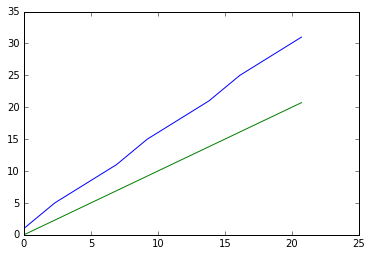

In [7]:
plt.plot(np.log(1/Eps),N); 
plt.plot(np.log(1/Eps), np.log(1/Eps)) # pour comparer à la droite de pente 1 passant par (0,0)
plt.show()

### 1.2 Résolution du problème de Cauchy

Pour vous guider dans la résolution du problème de Cauchy d'ordre $2$, on présente une fonction [t,y]=Euler(f,y_0,T,n) qui construit une solution approchée de l'EDO d'ordre un $y'(t) = G(t,y(t)), y(0) = y_0$ sur $[0,T]$ par une méthode d'Euler explicite, c'est-à-dire avec $\tau = T/N$,
$$
t_0 = 0, y_0\in \mathbb{R} 
\hbox{ et pour } 0\leq i\leq n-1, \left\{\begin{aligned}
&t_{i+1} = t_i + \tau \\
&y_{i+1} = y_i + \tau f(t_i,y_i) 
\end{aligned}\right.$$
Cette fonction retourne une liste $t = [t_0,\dots,t_n]$ et $y = [y_0,\dots,y_n]$.

In [8]:
def euler1D(G, y0, T, n):
    tau = T / float(n)
    y = np.zeros(n+1)                     # on créé deux tableaux de zéros pour stocker les pas de temps
    t = np.zeros(n+1)                     # et les valeurs de y
    y[0] = y0
    t[0] = 0
    for i in xrange(n):
        y[i+1] = y[i] + tau*G(t[i], y[i])
        t[i+1] = t[i] + tau
    return t,y

On teste ensuite cette fonction sur l'EDO $y'=y$:

|y - ysol|_infty=0.013468


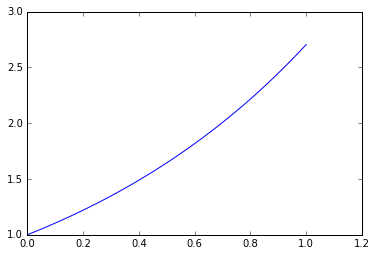

In [9]:
def G(t,y):
    return y
[t,y] = euler1D(G, y0=1, T=1, n=100)
print "|y - ysol|_infty=%g" % np.max(np.abs(y-np.exp(t)))
plt.plot(t,y)
#plt.plot(t,np.exp(t))
plt.show()

**Q3)** Transformer le problème de Cauchy pour l'EDO d'ordre deux 

$$
\left\{\begin{aligned}
&u_a''(t) = f(t) \hbox{ sur } [0,1] \\
&u_a(0) = 0, u_a'(0) = a
\end{aligned}\right.,$$

en un problème de Cauchy pour un système d'EDO d'ordre un, en les variables $(p(t),q(t)) = (u, u'(t)) \in \mathbb{R}^2$. En adaptant euler1D, écrire une fonction euler_ordre2(f, u0, uprime0, T, n) retournant deux tableaux de nombres, la liste des pas de temps $t_i = (Ti)/N$ pour $i\in 0,\dots,N$ et la liste des valeurs estimées $u_0,\dots,u_{n}$.

In [10]:
def euler_ordre2(f, u0, uprime0, T, n):
    tau = T / float(n)
    u = np.zeros(n+1)
    uprime = np.zeros(n+1)
    t = np.zeros(n+1)
    u[0] = u0
    uprime[0] = uprime0
    t[0] = 0
    for i in xrange(n):
        uprime[i+1] = uprime[i] + tau*f(t[i])
        u[i+1] = u[i] + tau*uprime[i]
        t[i+1] = t[i] + tau
    return t,u

On testera cette fonction avec le second membre suivant, en visualisant la solution pour $u_0 = 1, u'_0 = -.5$, $T=1$ et $n=50$:

In [11]:
def f(t):
    sigma = .05
    return (1.0/(sigma*np.sqrt(2*np.pi)))*np.exp(-np.power((t-0.2)/sigma,2.0))

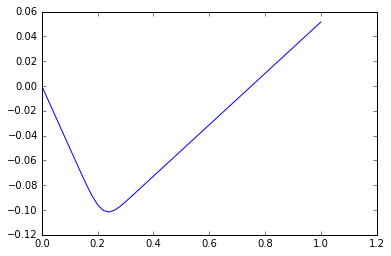

In [12]:
[t,x] = euler_ordre2(f,0,-.5,1,50)
plt.plot(t,x); plt.show()

**Q4)** Utiliser la fonction euler_ordre2 pour écrire une fonction Phi(n) calculant la valeur approchée de la solution du problème de Cauchy en $T=1$, i.e. $u_a(1)$ (on continuera à utiliser la fonction $f$ défini ci-dessus, et on prendra $n=50$). 

In [13]:
def Phi(a):
    [t,x] = euler_ordre2(f,0,a,1.,50)
    return x[50]

**Q5)** Tracer une solution approchée pour le problème original en combinant les fonctions Phi et dichotomie.

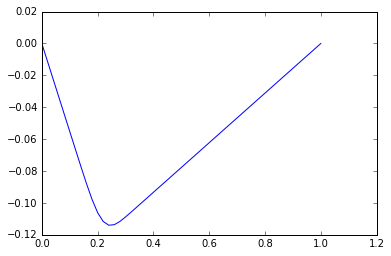

In [14]:
a=dichotomie(Phi,-1., .5); 
[t,x] = euler_ordre2(f,0,a,1,50)
plt.plot(t,x); plt.show()

## 2. Méthode des différences finies

On considère maintenant une deuxième méthode de résolution du problème, dont l'analyse a été présentée en cours. On approche l'EDO avec conditions de bord : 

$$
\left\{\begin{aligned}
&u''(t) = f(t) \hbox{ sur } ]0,1[ \\
&u(0) = u(1) = 0
\end{aligned}\right.$$

Par le système linéaire de dimension finie 

$$
\left\{\begin{aligned}
&u_{0} = 0, u_{n+1} = 0 \\
&\frac{1}{\tau^2}(u_{i-1} - 2 u_i + u_{i+1}) = f_i \hbox{ pour } 1\leq i\leq n
\end{aligned}\right.,$$

où $\tau = 1/n$ et $t_i = \tau i$ pour $0\leq i\leq n$ et $f_i = f(t_i)$.

**Q6)** On pose $x = (u_1,\dots, u_n)$ et $b = (f_1,\dots,f_n)$. Écrire le système linéaire sous la forme $A_\tau x = b$, où $L_\tau$ est une matrice symétrique. Écrire une fonction $L(n)$ calculant cette matrice. 

(Créer une matrice vide à l'aide de A=np.zero((n,n)) et la remplir en faisant des boucles. Pour accéder à l'élément (i,j) de A, on écrit A[i,j].)

In [15]:
def L(n):
    tau = 1.0/n
    A = np.zeros((n,n))
    for i in xrange(n):
        A[i,i] = -2
    for i in xrange(n-1):
        A[i,i+1] = 1
        A[i+1,i] = 1
    return A/(tau*tau)

**Q7)** On prend comme précédemment $n=50$. Construire le vecteur $s = [t_1,\dots,t_{n}]$, puis $b = f(s)$ (i.e. $b_i = f(s_i)$). Résoudre le système linéaire Utiliser la fonction d'algèbre linéaire np.linalg.solve(A,b), qui retourne une solution du système linéaire $Ax = b$. Afficher le résultat.

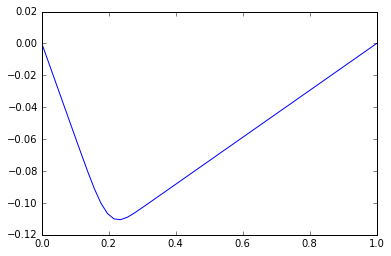

In [16]:
n=50
t = np.linspace(0,1,n+2)
b = f(t[1:-1])
A = L(n)
x = np.linalg.solve(A,b)
u = np.zeros(n+2)
u[1:-1] = x
plt.plot(t,u)
plt.show()

## 3. Une variante: régularisation de signaux

Dans cette partie on s'intéresse à un problème de débruitage. Étant donné un signal 1D $v:[0,1]\to\mathbb{R}$ continu et un paramètre $\alpha > 0$, on cherche à construire un signal régularisé en résolvant l'équation différentielle

$$
(D)\hspace{3cm} \left\{\begin{aligned}
&-u''(t) + \alpha (u(t) - v(t)) = 0 \hbox{ sur } ]0,1[ \\
&u'(0) = u'(1) = 0
\end{aligned}\right.,$$

que l'on discrétise de la manière suivante, en posant $\tau= 1/n$, $t_i = \tau i$ et $v_i = v(t_i)$,

$$
(D_n)\hspace{3cm} \left\{\begin{aligned}
&u_{0} = u_1, u_{n+1} = u_n \\
&-\frac{1}{\tau^2\alpha}(u_{i-1} - 2 u_i + u_{i+1}) + u_i = v_i \hbox{ pour } 1\leq i\leq n
\end{aligned}\right.,$$

**Q8)** De la même manière que précédemment, poser $x = (u_1,\dots, u_n)$ et écrire le système sous la forme $M_n x = b$ où la matrice $M$ et le vecteur $b$ sont à construire. Écrire une fonction $Mn(n,alpha)$ construisant la matrice $M_n$.

In [17]:
def Mn(n,alpha):
    tau = 1.0/n
    A = np.zeros((n,n))
    for i in xrange(n):
        A[i,i] = -2
    for i in xrange(n-1):
        A[i,i+1] = 1
        A[i+1,i] = 1
    A[0,0]=-1
    A[n-1,n-1]=-1
    return (-A/(alpha*tau*tau)) + np.eye(n)

**Q9)** Tester la résolution du système à partir du signal $v$ donné ci-dessous, auquel on a rajouté un bruit Gaussien (en utilisant la fonction np.random.random),  pour $\alpha=1000$ et $n=50$.

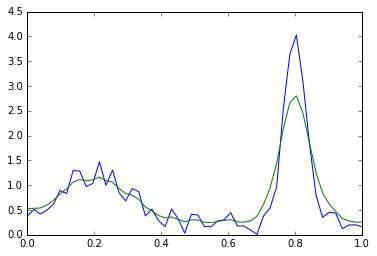

In [18]:
n=50
alpha=1000
t = np.linspace(0,1,n+2)
v = 4*np.exp(-500*np.square(t-.8)) + np.exp(-50*np.square(t-.2))
vv = v + .5*np.random.random(n+2) 
b = vv[1:-1]
A = Mn(n,alpha)
x = np.linalg.solve(A,b)
u = np.zeros(n+2)
u[1:n+1] = x
u[0] = u[1]
u[n+1] = u[n]
plt.plot(t,vv)
plt.plot(t,u)
plt.show()

**Q10)** Montrer que la discrétisation est stable en norme infinie, i.e. si $M_n x = b$, alors $\|x\|_\infty\leq \|b\|_\infty$, puis qu'elle est consistante. En déduire un résultat de  convergence des solutions de $(D_n)$ vers les solutions $\mathcal{C}^2$ de $(D)$.